### Importing dependancies

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### 1. Get data using pandas_datareader

In [39]:
ticker = "AAPL"

df = pdr.get_data_yahoo(ticker)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-13,28.892500,28.067499,28.799999,28.084999,183249600.0,25.808641
2015-11-16,28.559999,27.750000,27.844999,28.545000,152426800.0,26.231359
2015-11-17,28.762501,28.330000,28.730000,28.422501,110467600.0,26.118788
2015-11-18,29.372499,28.875000,28.940001,29.322500,186698800.0,26.945841
2015-11-19,29.937500,29.190001,29.410000,29.695000,173183200.0,27.288149


#### Plotting the closing price 

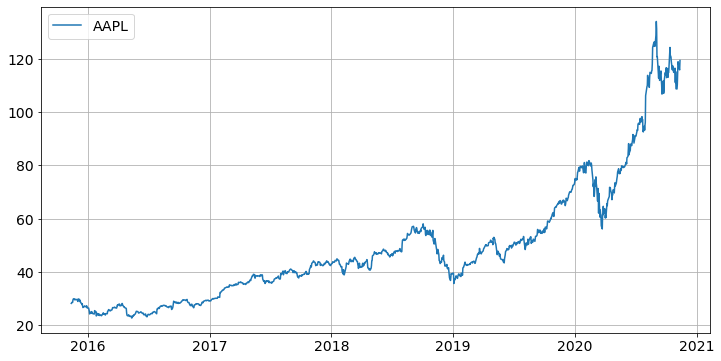

In [40]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["font.size"] = 14

df1 = df.reset_index()["Close"]

plt.plot(df.index,df1, label="{}".format(ticker))
plt.legend()
plt.grid(True)
plt.show()

### 2. Data Preprocessing 

#### Scaling the data to (0,1) range as LSTMs are known to be sensitive to the scale of the data

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# df1[:5]

#### In case of a time series it's ideal to split the data into training and testing sets

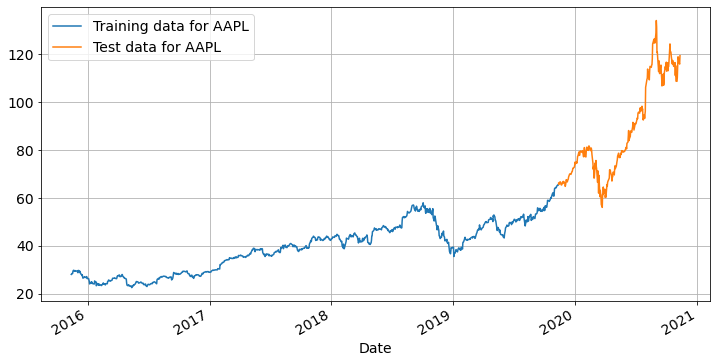

In [42]:
percentage_training_data = 0.80

train_data = df1[:int(percentage_training_data*df.shape[0])]

test_data = df1[int(percentage_training_data*df.shape[0]):]

# Plot the training and test values of closing price 
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["font.size"] = 14

df["Close"][:int(percentage_training_data*df.shape[0])].plot(label="Training data for {}".format(ticker))
df["Close"][int(percentage_training_data*df.shape[0]):].plot(label="Test data for {}".format(ticker))
plt.legend(); plt.grid(True); plt.show()

#### Create features and target variables based on timesteps

In [43]:
def create_features_targets(data, timesteps):
    features = []
    target = []
    for i in range(len(data)-timesteps-1):
        features.append(list(data[i:i+timesteps]))
        target.append(data[i+timesteps])
    return np.array(features), np.array(target)

timesteps = 30

X_train, y_train = create_features_targets(train_data, timesteps=timesteps)

X_test, y_test = create_features_targets(test_data, timesteps=timesteps)

### 3. Create a stacked LSTM model

In [44]:
## Reshaping input for LSTM as : [sample_size, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [45]:
## Creating the stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()

model.add(LSTM(timesteps,
               return_sequences=True,
               input_shape=(timesteps, 1)))

model.add(LSTM(timesteps))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [46]:
## Fit the model
model = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=100, 
          batch_size=50, 
          verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 56ms/step - loss: 0.0080 - val_loss: 0.0419
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 3/100
20/20 [==============================] - 0s 15ms/step - loss: 3.1070e-04 - val_loss: 0.0089
Epoch 4/100
20/20 [==============================] - 0s 15ms/step - loss: 2.5935e-04 - val_loss: 0.0047
Epoch 5/100
20/20 [==============================] - 0s 15ms/step - loss: 2.2822e-04 - val_loss: 0.0036
Epoch 6/100
20/20 [==============================] - 0s 17ms/step - loss: 2.1472e-04 - val_loss: 0.0033
Epoch 7/100
20/20 [==============================] - 0s 18ms/step - loss: 2.0759e-04 - val_loss: 0.0028
Epoch 8/100
20/20 [==============================] - 0s 19ms/step - loss: 2.0403e-04 - val_loss: 0.0028
Epoch 9/100
20/20 [==============================] - 0s 18ms/step - loss: 1.9812e-04 - val_loss: 0.0026
Epoch 10/100
20/20 [==============================] - 0s 18ms/step - los

20/20 [==============================] - 0s 17ms/step - loss: 8.5375e-05 - val_loss: 9.7940e-04
Epoch 80/100
20/20 [==============================] - 0s 17ms/step - loss: 8.0502e-05 - val_loss: 0.0011
Epoch 81/100
20/20 [==============================] - 0s 16ms/step - loss: 8.5003e-05 - val_loss: 0.0011
Epoch 82/100
20/20 [==============================] - 0s 17ms/step - loss: 8.4732e-05 - val_loss: 0.0010
Epoch 83/100
20/20 [==============================] - 0s 17ms/step - loss: 8.6933e-05 - val_loss: 9.5267e-04
Epoch 84/100
20/20 [==============================] - 0s 18ms/step - loss: 8.0597e-05 - val_loss: 9.9110e-04
Epoch 85/100
20/20 [==============================] - 0s 17ms/step - loss: 7.9692e-05 - val_loss: 0.0010
Epoch 86/100
20/20 [==============================] - 0s 16ms/step - loss: 7.8965e-05 - val_loss: 0.0011
Epoch 87/100
20/20 [==============================] - 0s 16ms/step - loss: 7.8267e-05 - val_loss: 9.8387e-04
Epoch 88/100
20/20 [==============================] 

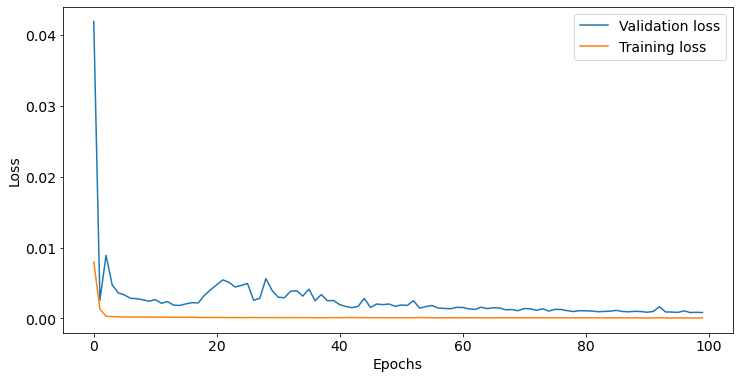

In [47]:
plt.plot(model.history["val_loss"], label="Validation loss")
plt.plot(model.history["loss"], label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 4. Predict the output for test data

In [48]:
## Model predictions on test data
train_predictions = model.model.predict(X_train)
test_predictions = model.model.predict(X_test)

## Tranforming predictions back to original values
train_predictions = scaler.inverse_transform(train_predictions) 
test_predictions = scaler.inverse_transform(test_predictions)

In [50]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Training MSE",math.sqrt(mean_squared_error(y_train,train_predictions)))
print("Training MAE",math.sqrt(mean_absolute_error(y_train,train_predictions)))

print("Testing MSE",math.sqrt(mean_squared_error(y_test, test_predictions)))
print("Testing MAE",math.sqrt(mean_absolute_error(y_test, test_predictions)))

Training MSE 40.77617350178376
Training MAE 6.283645692783606
Testing MSE 91.91970558371459
Testing MAE 9.472203193901162


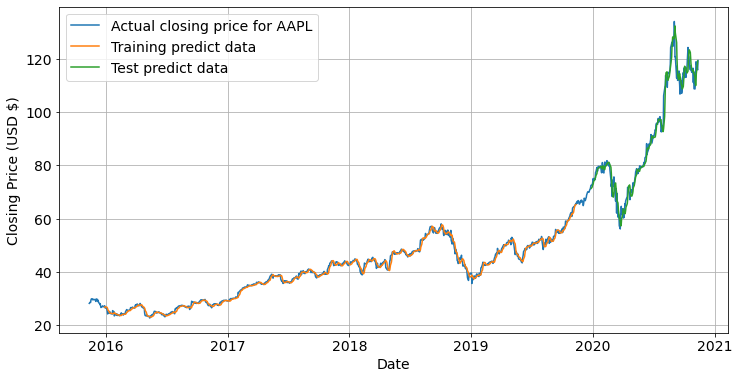

In [51]:
### Plotting 
# shift train predictions for plotting
look_back=timesteps
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predictions)+look_back, :] = train_predictions
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predictions)+(look_back*2)+1:len(df1)-1, :] = test_predictions
# plot baseline and predictions
plt.plot(df.index, scaler.inverse_transform(df1), label = "Actual closing price for {}".format(ticker))
plt.plot(df.index, trainPredictPlot, label = "Training predict data")
plt.plot(df.index, testPredictPlot, label = "Test predict data")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD $)")
plt.legend()
plt.grid(True)
plt.show()

### 5. Predict closing price for the next 1 month

In [54]:
x_input = test_data[len(test_data)-timesteps:].reshape(1,-1)

temp_input = list(x_input)[0].tolist()

lst_output=[]
n_steps=timesteps
i=0

days_ahead = 30

while(i<days_ahead):
    
    if(len(temp_input)>timesteps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

future = scaler.inverse_transform(lst_output)

df_prediction = pd.concat([pd.DataFrame([df.index.max()+datetime.timedelta(i+1) for i in range(days_ahead)],
                                        columns=["Date"]), 
                           pd.DataFrame(future,
                                        columns=["Prediction"])], axis=1).set_index("Date")

final_df_with_prediction = pd.concat([df, df_prediction])

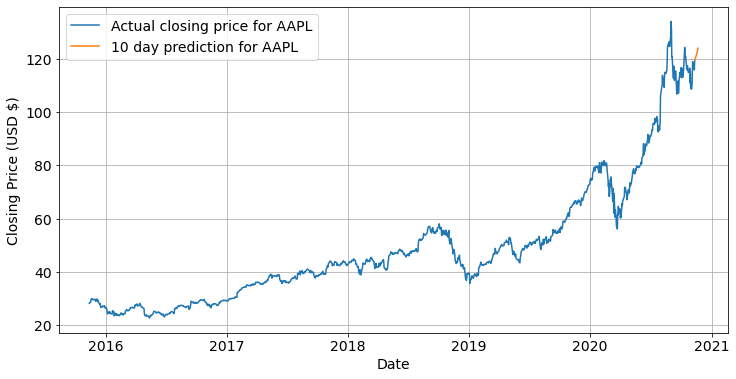

In [53]:
plt.plot(final_df_with_prediction["Close"],  label = "Actual closing price for {}".format(ticker))
plt.plot(final_df_with_prediction["Prediction"],  label = "{} day prediction for {}".format(days_ahead,ticker))
plt.xlabel("Date")
plt.ylabel("Closing Price (USD $)")
plt.legend()
plt.grid(True)
plt.show()